In [1]:
# ch08 聚类
# 步骤1: 创建SparkSession对象
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('K_means').getOrCreate()

In [2]:
# 读取数据集
df = spark.read.csv('iris_dataset.csv', inferSchema=True, header=True)



In [3]:
# 探究数据分析
print(df.count(), len(df.columns))

150 5


In [4]:
df.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



In [5]:
from pyspark.sql.functions import rand
df.orderBy(rand()).show(10, False)

+------------+-----------+------------+-----------+----------+
|sepal_length|sepal_width|petal_length|petal_width|species   |
+------------+-----------+------------+-----------+----------+
|7.2         |3.0        |5.8         |1.6        |virginica |
|5.1         |3.4        |1.5         |0.2        |setosa    |
|4.8         |3.0        |1.4         |0.3        |setosa    |
|7.7         |3.0        |6.1         |2.3        |virginica |
|6.1         |3.0        |4.9         |1.8        |virginica |
|7.2         |3.2        |6.0         |1.8        |virginica |
|5.5         |3.5        |1.3         |0.2        |setosa    |
|6.4         |2.7        |5.3         |1.9        |virginica |
|5.6         |2.5        |3.9         |1.1        |versicolor|
|4.9         |2.4        |3.3         |1.0        |versicolor|
+------------+-----------+------------+-----------+----------+
only showing top 10 rows



In [7]:
# 步骤4：特征工程
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler
input_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
vec_assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
final_data = vec_assembler.transform(df)

In [8]:
# 步骤5: 构建K均值聚类模型
from pyspark.ml.clustering import KMeans
errors=[]
# K的范围从2-10，从而使用肘部法则确定具体K的值
for k in range(2, 10):
    kemans = KMeans(featuresCol='features', k=k)
    model = kemans.fit(final_data)
    intral_distance = model.computeCost(final_data)
    errors.append(intral_distance)

In [9]:
print(errors)

[152.36870647734008, 78.94506582597637, 57.47147508745658, 46.53558205128334, 45.96395128205201, 37.4860212121211, 36.35147828282878, 34.79115066845024]


In [10]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [17]:
from matplotlib.font_manager import fontManager
import os
 
fonts = [font.name for font in fontManager.ttflist if 
         os.path.exists(font.fname) and os.stat(font.fname).st_size>1e6] 
 
for font in fonts:
    print(font)


Devanagari Sangam MN
Lucida Grande
American Typewriter
Avenir Next Condensed
Papyrus
.Aqua Kana
PT Sans
Menlo
Charter
Kailasa
Hiragino Mincho ProN
.SF Compact Text
Apple SD Gothic Neo
Gill Sans
Snell Roundhand
.SF NS Rounded
Mishafi
Geeza Pro
Heiti TC
Hiragino Maru Gothic Pro
Baskerville
Hiragino Sans
Helvetica
PingFang HK
Hiragino Sans
PT Serif
.Arabic UI Display
Diwan Thuluth
Heiti TC
Hiragino Sans GB
Hiragino Sans
Noto Sans Kannada
Hiragino Sans
Copperplate
Arial Unicode MS
Cochin
Damascus
Hiragino Sans
Hiragino Sans
Avenir Next
Arial Unicode MS
Noto Sans Myanmar
AppleGothic
Kohinoor Devanagari
Athelas
.Helvetica Neue DeskInterface
Mukta Mahee
Hiragino Sans
Superclarendon
AppleMyungjo
Hoefler Text
System Font
Hiragino Sans
Palatino
Hiragino Sans
Hiragino Sans
Songti SC
Seravek
Helvetica Neue
Thonburi
Avenir
Noto Serif Myanmar
Iowan Old Style


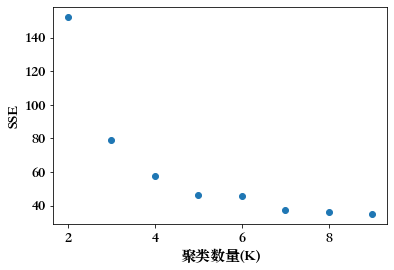

In [24]:
mpl.rcParams['font.family'] =  'Songti SC'
mpl.rcParams['font.sans-serif'] = ['Songti SC']
mpl.rcParams['font.size'] = 15

cluster_number = range(2, 10)
plt.xlabel('聚类数量(K)')
plt.ylabel('SSE')
plt.scatter(cluster_number, errors)
plt.show()

In [27]:
# 肘部位于K=3的位置
kmeans = KMeans(featuresCol='features', k=3)
model = kmeans.fit(final_data)
model.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   50|
|         2|   39|
|         0|   61|
+----------+-----+



In [29]:
# 可以使用transform函数为原始数据集指定数量，并且使用groupBY函数验证分组
predictions = model.transform(final_data)
predictions.groupBy('species', 'prediction').count().show()

+----------+----------+-----+
|   species|prediction|count|
+----------+----------+-----+
| virginica|         2|   36|
| virginica|         0|   14|
|versicolor|         0|   47|
|    setosa|         1|   50|
|versicolor|         2|    3|
+----------+----------+-----+



In [30]:
# 步骤6: 聚类可视化
pandas_df = predictions.toPandas()
pandas_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species,features,prediction
0,5.1,3.5,1.4,0.2,setosa,"[5.1, 3.5, 1.4, 0.2]",1
1,4.9,3.0,1.4,0.2,setosa,"[4.9, 3.0, 1.4, 0.2]",1
2,4.7,3.2,1.3,0.2,setosa,"[4.7, 3.2, 1.3, 0.2]",1
3,4.6,3.1,1.5,0.2,setosa,"[4.6, 3.1, 1.5, 0.2]",1
4,5.0,3.6,1.4,0.2,setosa,"[5.0, 3.6, 1.4, 0.2]",1


In [ ]:
# 引入所需的库绘制可视化图，并观察聚类
from mpl_toolkits.mplot3d import Axes3D
cluster_vis = plt.figure(figsize=(12, 10).gca(projection='3d'))
cluster_vis.scatter(pandas_df.sepal_length, 
                   pandas_df.sepal_width)